In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import re
from collections import Counter


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mihat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mihat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mihat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
cwd = os.getcwd()
df = pd.read_csv( os.path.join(cwd, 'full_dataset_all_labels.csv'))
stop_words=set(stopwords.words('english') + list(string.punctuation))
stop_words.add('rt') # add word rt (meaning retweet) to stop words
df = pd.read_csv('full_dataset_all_labels.csv')
#df = df.sample(10000)

In [3]:
i=21750
print(df['text'].iloc[i])
#print(df['tokenized_text'].iloc[i])
df[df['text'].str.contains("<USER> that's not how it works")]

RETARD 

I'ts my flippen opinion anyways and how about get a life intead of reporting peoplego get laid you stupid gay virgin


,text,label
77205,<USER> that's not how it works bitch <URL>,vulgar


In [4]:
def print_some_texts(columns, df):
    text_idxs = [47, 7240, 7241, 8013, 14500, 16500, 16304, 18300,  21750, 34036, 45159, 71920]
    for i in text_idxs:
        for column in columns:
            print(df[column].iloc[i])
#print_some_texts(['text'])

def tokenize(text):
    #print(text)
    text = preprocess_text(text)
    #print(text)
    tokens = word_tokenize(text)
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation). (adapted from lab example)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if token not in stop_words and len(token) > 2:
                filtered_tokens.append(token)
    return filtered_tokens
    

def preprocess_text(text):
    text = re.sub(r"http\S+", " ", text)            # remove urls
    text = re.sub("@[A-Za-z0-9]+","", text)         # remove twitter handle
    text = re.sub("&amp;","", text)                  # &amp; is a special character for ampersand
    text = re.sub('<USER>', '', text)               # remove '<USER>' as there are some such strings as user or url is masked with this string
    text = re.sub('<URL>', '', text)
    text = text.lower() 
    text = re.sub('[^a-zA-Z]', ' ', text)           # Remove punctuations
    text = text.lower()                             # Convert to lowercase
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)#remove tags
    text = re.sub("(\\d|\\W)+"," ",text)            # remove special characters and digits
    return text
    
    
def stemming(tokens):
    stemmer = SnowballStemmer("english")
    stems = [stemmer.stem(token) for token in tokens]
    return stems

def lemmatizing(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas

In [5]:
df['preprocessed_text']=df['text'].apply(preprocess_text)
df['tokenized_text']= df['preprocessed_text'].apply(tokenize) 

df['stems']= df['tokenized_text'].apply(stemming) 
df['lemmas']= df['tokenized_text'].apply(lemmatizing) 

In [6]:
with pd.option_context("max_colwidth", 1000):
    print(df[['text', 'tokenized_text', 'stems', 'lemmas']].loc[[50896,22,77618]].to_latex(index=False))

\begin{tabular}{llll}
\toprule
                                             text &         tokenized\_text &                 stems &                lemmas \\
\midrule
RT @LookinnnAss: - you a pussy I see yo whiskers! & [pussy, see, whiskers] & [pussi, see, whisker] & [pussy, see, whisker] \\
                                fucking nazi mods &  [fucking, nazi, mods] &     [fuck, nazi, mod] &  [fucking, nazi, mod] \\
                     <USER> who in the hell cares &          [hell, cares] &          [hell, care] &          [hell, care] \\
\bottomrule
\end{tabular}



In [7]:
df[(df['lemmas']!=df['tokenized_text']) & (df['lemmas'].str.len() < 4)].sample(10)

,text,label,preprocessed_text,tokenized_text,stems,lemmas
44910,Dekalb police are some hoes...,offensive,dekalb police are some hoes,"[dekalb, police, hoes]","[dekalb, polic, hoe]","[dekalb, police, hoe]"
10426,RT @QueenNigger: I'M NOT RACIST YOU FUCKING NI...,harassment,rt i m not racist you fucking niggers,"[racist, fucking, niggers]","[racist, fuck, nigger]","[racist, fucking, nigger]"
27994,ged likes penis =)\n\n 1\n0 0,insult,ged likes penis,"[ged, likes, penis]","[ged, like, peni]","[ged, like, penis]"
59888,@ameerahusman Islam is for liars. http://t.co/...,racist,islam is for liars,"[islam, liars]","[islam, liar]","[islam, liar]"
51698,RT @SheswantstheD: these hoes ain't loyal http...,offensive,rt these hoes ain t loyal,"[hoes, loyal]","[hoe, loyal]","[hoe, loyal]"
40168,-5 RT @LoveMeDarlingg: 10. How many hoes do yo...,offensive,rt how many hoes do you really have,"[many, hoes, really]","[mani, hoe, realli]","[many, hoe, really]"
44110,All y'all bitches corny lol,offensive,all y all bitches corny lol,"[bitches, corny, lol]","[bitch, corni, lol]","[bitch, corny, lol]"
1272,inb4 removed by mods,abuse,inb removed by mods,"[inb, removed, mods]","[inb, remov, mod]","[inb, removed, mod]"
40753,@David_Hunninck all bitches eh. hahah,offensive,hunninck all bitches eh hahah,"[hunninck, bitches, hahah]","[hunninck, bitch, hahah]","[hunninck, bitch, hahah]"
18637,Most immigrants have been blessed with mendacity,hostile,most immigrants have been blessed with mendacity,"[immigrants, blessed, mendacity]","[immigr, bless, mendac]","[immigrant, blessed, mendacity]"


### get dataframe with most frequent words for each label

In [8]:
def labels_most_frequent_words(df, label, column, n_words = 10, visualise = False):
    # returns sorted list (decreasing) of n most frequent words for a label
    all_words_list=df[df['label']==label][column].sum()
    all_words_count = dict(Counter(all_words_list))
    words_freq = [(word, all_words_count[word]) for word in all_words_count]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    if visualise:
        top_n_words_freq = words_freq[:n_words]
        x,y=map(list,zip(*top_n_words_freq))
        sns.barplot(x=y, y=x)
        
    #print(words_freq)
    return words_freq[:n_words]

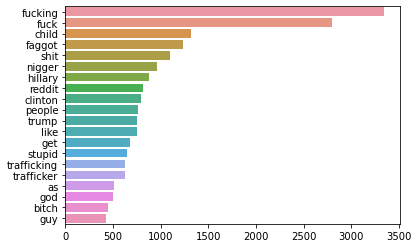

In [9]:
words_freq = labels_most_frequent_words(df, label='homophobic', column='lemmas', n_words = 20, visualise = True)
#print(words_freq)

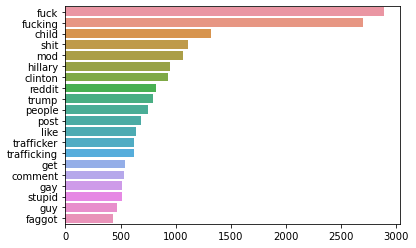

In [10]:
words_freq = labels_most_frequent_words(df, label='abuse', column='lemmas', n_words = 20, visualise = True)

In [11]:
# df with most frequent/significant/important words for each label

def get_n_most_freq_words_df(df, top_n_words, words_column):
    unique_labels = set(df['label'])
    df_labels = pd.DataFrame( columns=['label', 'n_most_freq_words', 'n_most_freq_words_frequencies'])
    for label in unique_labels:
        words_freq = labels_most_frequent_words(df, label=label, column=words_column, n_words = top_n_words, visualise = False)
        words = [word for word, freq in words_freq]
        df_labels = df_labels.append({'label': label, 'n_most_freq_words':words,'n_most_freq_words_frequencies':words_freq}, ignore_index=True)
    return df_labels

In [12]:
df_labels_freq = get_n_most_freq_words_df(df, 100, 'lemmas')

## Words that occur in each of top 10 words for label

In [13]:
df_labels_freq_10 = get_n_most_freq_words_df(df, 10, 'lemmas')

In [14]:
df_labels_freq_10

,label,n_most_freq_words,n_most_freq_words_frequencies
0,profane,"[fucktrump, fuck, dickhead, trump, fucking, do...","[(fucktrump, 315), (fuck, 133), (dickhead, 110..."
1,offensive,"[bitch, hoe, like, pussy, nigga, as, got, fuck...","[(bitch, 11195), (hoe, 4212), (like, 2378), (p..."
2,threat,"[die, as, kill, going, block, fuck, must, jim,...","[(die, 1168), (as, 772), (kill, 505), (going, ..."
3,obscene,"[fuck, suck, shit, fucking, as, nigger, bitch,...","[(fuck, 9921), (suck, 4089), (shit, 3225), (fu..."
4,hostile,"[people, woman, black, like, white, fucking, l...","[(people, 567), (woman, 540), (black, 382), (l..."
5,insult,"[fuck, suck, nigger, fucking, faggot, as, bitc...","[(fuck, 7976), (suck, 3746), (nigger, 2890), (..."
6,harassment,"[jew, fucking, whitegenocide, white, muslim, c...","[(jew, 2581), (fucking, 712), (whitegenocide, ..."
7,abuse,"[fuck, fucking, child, shit, mod, hillary, cli...","[(fuck, 2889), (fucking, 2694), (child, 1317),..."
8,homophobic,"[fucking, fuck, child, faggot, shit, nigger, h...","[(fucking, 3346), (fuck, 2802), (child, 1321),..."
9,vulgar,"[shit, hell, damn, fuck, as, bitch, like, fuck...","[(shit, 1126), (hell, 1033), (damn, 897), (fuc..."


In [15]:
tmp = df_labels_freq_10['n_most_freq_words'].explode()
tmp.value_counts()

fucking     12
fuck        12
shit        10
as           9
like         9
            ..
islam        1
jim          1
sexist       1
girl         1
mohammed     1
Name: n_most_freq_words, Length: 73, dtype: int64

### TF-IDF most important words for each label

In [16]:
def get_top_n_tfidf_words_df(df, top_n_words, words_column):
    '''combines documents for each label into a single string (document) and then use this to get most important words with tf-idf
    for each document(label), return dataframe with labels and most important (tf-idf) words (in order, decreasing) for that label'''
    unique_labels = set(df['label'])
    words_by_label_string = {}
   
    for label in unique_labels:
        tmp = df[df['label'] == label][words_column]
        tmp = tmp.apply(pd.Series).stack().reset_index(drop=True)
        words_by_label_string[label] = ' '.join(list(tmp.values))
    labels, documents = list(words_by_label_string.keys()), list(words_by_label_string.values())
        
    tfIdfVectorizer=TfidfVectorizer()
    X_tf_idf_non_array = tfIdfVectorizer.fit_transform(documents)
    X_tf_idf = X_tf_idf_non_array.toarray()
    vocab = tfIdfVectorizer.vocabulary_
    reverse_vocab = {v:k for k,v in vocab.items()}
    feature_names = tfIdfVectorizer.get_feature_names()
    df_tfidf = pd.DataFrame(X_tf_idf, columns = feature_names)
    idx = X_tf_idf.argsort(axis=1) #sort and get idx for sorted values
    tfidf_max_n = idx[:,-top_n_words:] # select top n words from sorted indexes
    df_tfidf['label'] = pd.Series(labels, index=df_tfidf.index)
    df_tfidf['top_n_tfidf_words'] = [[reverse_vocab.get(item) for item in row][::-1] for row in tfidf_max_n]
    
    return df_tfidf[['label', 'top_n_tfidf_words']]


In [17]:
df_labels_tf_idf = get_top_n_tfidf_words_df(df, 100, 'lemmas')

In [18]:
df_labels_tf_idf

,label,top_n_tfidf_words
0,profane,"[fucktrump, dickhead, fuck, trump, trumpisatra..."
1,offensive,"[bitch, hoe, like, pussy, nigga, as, got, fuck..."
2,threat,"[die, as, kill, supertr, going, wale, jim, rvv..."
3,obscene,"[fuck, suck, shit, fucking, nigger, as, wikipe..."
4,hostile,"[people, woman, black, like, white, fucking, m..."
5,insult,"[fuck, suck, nigger, faggot, fucking, as, bitc..."
6,harassment,"[jew, whitegenocide, fucking, whitelivesmatter..."
7,abuse,"[fuck, fucking, trafficker, trafficking, mod, ..."
8,homophobic,"[fucking, fuck, trafficker, trafficking, reddi..."
9,vulgar,"[shit, hell, damn, fuck, as, bitch, like, fuck..."


In [19]:
# combine tf-idf and most frequent words:
df_labels = pd.merge(df_labels_freq, df_labels_tf_idf, on='label')

In [20]:
df_labels

,label,n_most_freq_words,n_most_freq_words_frequencies,top_n_tfidf_words
0,profane,"[fucktrump, fuck, dickhead, trump, fucking, do...","[(fucktrump, 315), (fuck, 133), (dickhead, 110...","[fucktrump, dickhead, fuck, trump, trumpisatra..."
1,offensive,"[bitch, hoe, like, pussy, nigga, as, got, fuck...","[(bitch, 11195), (hoe, 4212), (like, 2378), (p...","[bitch, hoe, like, pussy, nigga, as, got, fuck..."
2,threat,"[die, as, kill, going, block, fuck, must, jim,...","[(die, 1168), (as, 772), (kill, 505), (going, ...","[die, as, kill, supertr, going, wale, jim, rvv..."
3,obscene,"[fuck, suck, shit, fucking, as, nigger, bitch,...","[(fuck, 9921), (suck, 4089), (shit, 3225), (fu...","[fuck, suck, shit, fucking, nigger, as, wikipe..."
4,hostile,"[people, woman, black, like, white, fucking, l...","[(people, 567), (woman, 540), (black, 382), (l...","[people, woman, black, like, white, fucking, m..."
5,insult,"[fuck, suck, nigger, fucking, faggot, as, bitc...","[(fuck, 7976), (suck, 3746), (nigger, 2890), (...","[fuck, suck, nigger, faggot, fucking, as, bitc..."
6,harassment,"[jew, fucking, whitegenocide, white, muslim, c...","[(jew, 2581), (fucking, 712), (whitegenocide, ...","[jew, whitegenocide, fucking, whitelivesmatter..."
7,abuse,"[fuck, fucking, child, shit, mod, hillary, cli...","[(fuck, 2889), (fucking, 2694), (child, 1317),...","[fuck, fucking, trafficker, trafficking, mod, ..."
8,homophobic,"[fucking, fuck, child, faggot, shit, nigger, h...","[(fucking, 3346), (fuck, 2802), (child, 1321),...","[fucking, fuck, trafficker, trafficking, reddi..."
9,vulgar,"[shit, hell, damn, fuck, as, bitch, like, fuck...","[(shit, 1126), (hell, 1033), (damn, 897), (fuc...","[shit, hell, damn, fuck, as, bitch, like, fuck..."


### tf-idf, word2vec, glove, fasttext

In [21]:
import gensim
import gensim.downloader
from gensim.models.fasttext import load_facebook_vectors

In [22]:
model_gn_glove = gensim.downloader.load('glove-wiki-gigaword-300')
model_gn_word2vec = gensim.downloader.load('word2vec-google-news-300')

In [23]:
df_labels[df_labels['label']=='vulgar']['n_most_freq_words'].iloc[0][0]

'shit'

In [24]:
def get_word_embeddings(labels, df, list_of_words_column, model_gn, top_n):
    word_clusters = []
    embedding_clusters = []
    model_unknown_words = []
    for label in labels:
        label_words = df[df['label']==label][list_of_words_column].iloc[0]
        embeddings = []
        words = []
        for word in label_words:
            try:
                embeddings.append(model_gn[word])
                words.append(word)
            except KeyError:
                #print(word)
                model_unknown_words.append(word)
                pass
            
        words = words[:top_n]
        embeddings = embeddings[:top_n]

        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    #print(model_unknown_words)
    return word_clusters, embedding_clusters

def displayDF(word_clusters, labels):
    df = pd.DataFrame(dict(zip(labels, word_clusters)))  
    display(df)
    
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    # function code taken from labs
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.annotate(label.upper(), alpha=1.0, xy=(np.mean(x), np.mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()
    
def plotTSNE(title, labels, word_clusters, embedding_clusters, filename = None):
    # function code adapted from labs
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, labels, embeddings_en_2d, word_clusters, filename)
    
def plotMDS(title, labels, word_clusters, embedding_clusters, filename = None):
    # function code adapted from labs
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, labels, embeddings_en_2d, word_clusters, filename)
    
def plotPCA(title, labels, word_clusters, embedding_clusters, filename = None):
    # function code adapted from labs
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, labels, embeddings_en_2d, word_clusters, filename)
    

### word2vec embeddings (pretrained) visualisation

In [25]:
n_significant_words = 20
words_column = 'top_n_tfidf_words'
unique_labels = set(df['label'])
word_clusters, embedding_clusters = get_word_embeddings(unique_labels, df_labels, words_column, model_gn_word2vec, n_significant_words)

In [26]:
#displayDF(word_clusters, unique_labels)

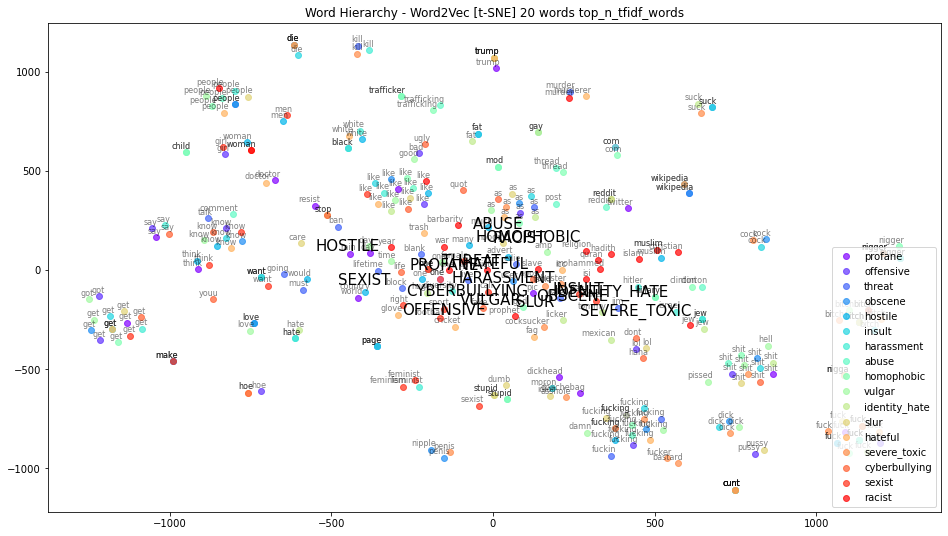

In [27]:
plotTSNE(f"Word Hierarchy - Word2Vec [t-SNE] {n_significant_words} words {words_column}", unique_labels, word_clusters, embedding_clusters, 
         f"Word Hierarchy - Word2Vec [t-SNE] {n_significant_words} words {words_column}.png")

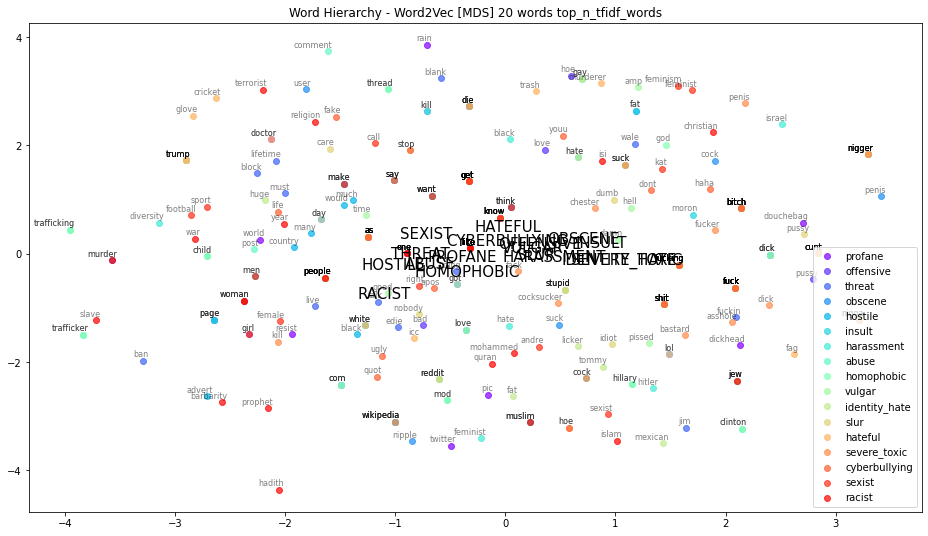

In [28]:
plotMDS(f"Word Hierarchy - Word2Vec [MDS] {n_significant_words} words {words_column}", unique_labels, word_clusters, embedding_clusters, 
        f"Word Hierarchy - Word2Vec [MDS] {n_significant_words} words {words_column}.png")

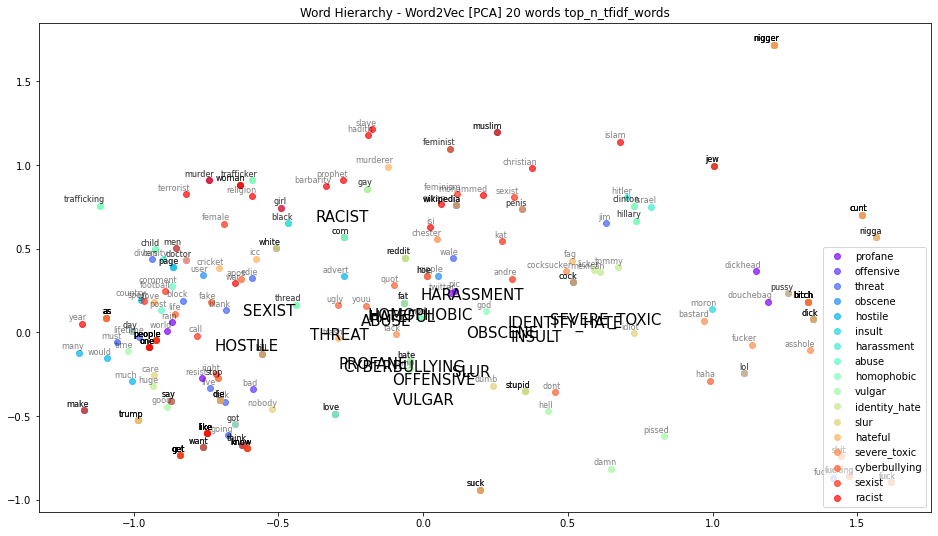

In [29]:
plotPCA(f"Word Hierarchy - Word2Vec [PCA] {n_significant_words} words {words_column}", unique_labels, word_clusters, embedding_clusters, 
        f"Word Hierarchy - Word2Vec [PCA] {n_significant_words} words {words_column}.png")

In [30]:
df_labels.sample(4)

,label,n_most_freq_words,n_most_freq_words_frequencies,top_n_tfidf_words
0,profane,"[fucktrump, fuck, dickhead, trump, fucking, do...","[(fucktrump, 315), (fuck, 133), (dickhead, 110...","[fucktrump, dickhead, fuck, trump, trumpisatra..."
1,offensive,"[bitch, hoe, like, pussy, nigga, as, got, fuck...","[(bitch, 11195), (hoe, 4212), (like, 2378), (p...","[bitch, hoe, like, pussy, nigga, as, got, fuck..."
9,vulgar,"[shit, hell, damn, fuck, as, bitch, like, fuck...","[(shit, 1126), (hell, 1033), (damn, 897), (fuc...","[shit, hell, damn, fuck, as, bitch, like, fuck..."
13,severe_toxic,"[fuck, suck, as, shit, faggot, bitch, fucking,...","[(fuck, 7319), (suck, 3496), (as, 2115), (shit...","[fuck, suck, as, shit, faggot, fucksex, yourse..."


### Glove embeddings (pretrained) visualisations

In [37]:
n_significant_words = 30
words_column = 'n_most_freq_words'
word_clusters, embedding_clusters = get_word_embeddings(unique_labels, df_labels, words_column, model_gn_glove, n_significant_words)

In [38]:
displayDF(word_clusters, unique_labels)

,profane,offensive,threat,obscene,hostile,insult,harassment,abuse,homophobic,vulgar,identity_hate,slur,hateful,severe_toxic,cyberbullying,sexist,racist
0,fuck,bitch,die,fuck,people,fuck,jew,fuck,fucking,shit,nigger,cunt,bitch,fuck,bitch,sexist,islam
1,trump,hoe,as,suck,woman,suck,fucking,fucking,fuck,hell,jew,fucking,faggot,suck,fake,mkr,muslim
2,fucking,like,kill,shit,black,nigger,white,child,child,damn,fat,fuck,like,as,like,woman,mohammed
3,like,pussy,going,fucking,like,fucking,muslim,shit,faggot,fuck,gay,idiot,nigga,shit,get,girl,religion
4,shit,nigga,block,as,white,faggot,cunt,mod,shit,as,fuck,shit,nigger,faggot,fucking,kat,isi
5,doctor,as,fuck,nigger,fucking,as,like,hillary,nigger,bitch,die,dumb,people,bitch,shit,female,jew
6,get,got,must,bitch,love,bitch,people,clinton,hillary,like,faggot,lol,white,fucking,know,like,prophet
7,twitter,fuck,jim,faggot,men,fat,hitler,reddit,reddit,fucking,fucking,bitch,as,die,fuck,call,quran
8,resist,get,wale,cunt,country,shit,feminist,trump,clinton,get,nigga,as,get,cunt,as,men,people
9,world,shit,fucking,wikipedia,would,cunt,nigger,people,people,one,suck,pussy,trump,nigger,stop,think,like


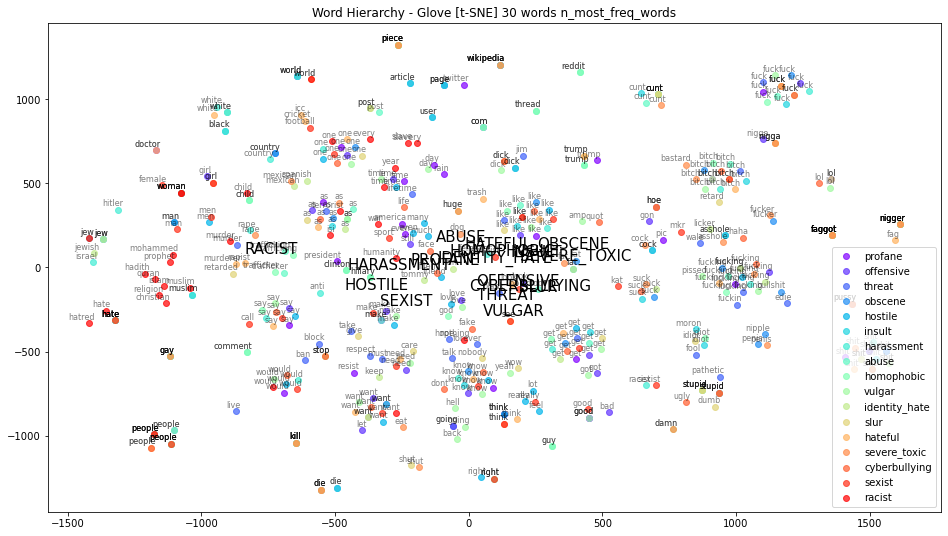

In [39]:
plotTSNE(f"Word Hierarchy - Glove [t-SNE] {n_significant_words} words {words_column}", unique_labels, word_clusters,embedding_clusters, 
         f"Word Hierarchy - Glove [t-SNE] {n_significant_words} words {words_column}.png")

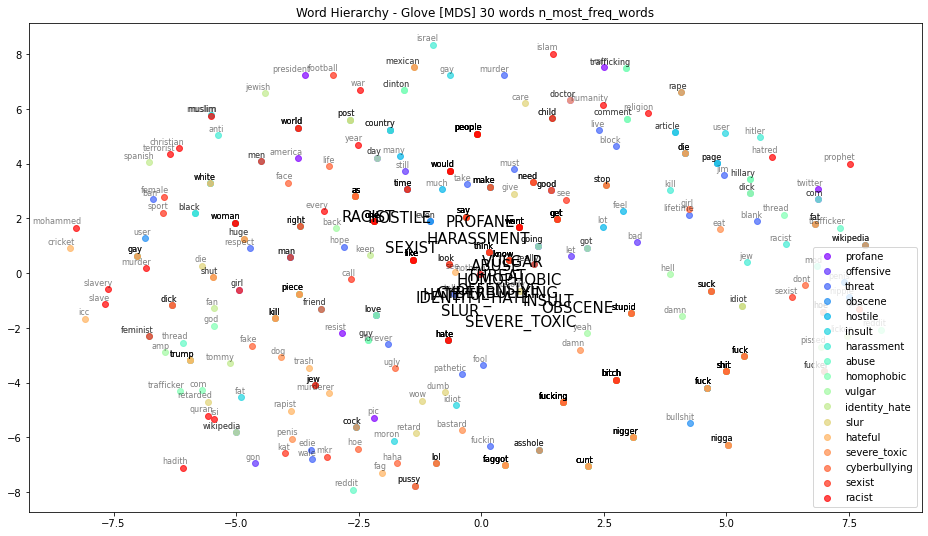

In [40]:
plotMDS(f"Word Hierarchy - Glove [MDS] {n_significant_words} words {words_column}",unique_labels, word_clusters, embedding_clusters, 
        f"Word Hierarchy - Glove [MDS] {n_significant_words} words {words_column}.png")

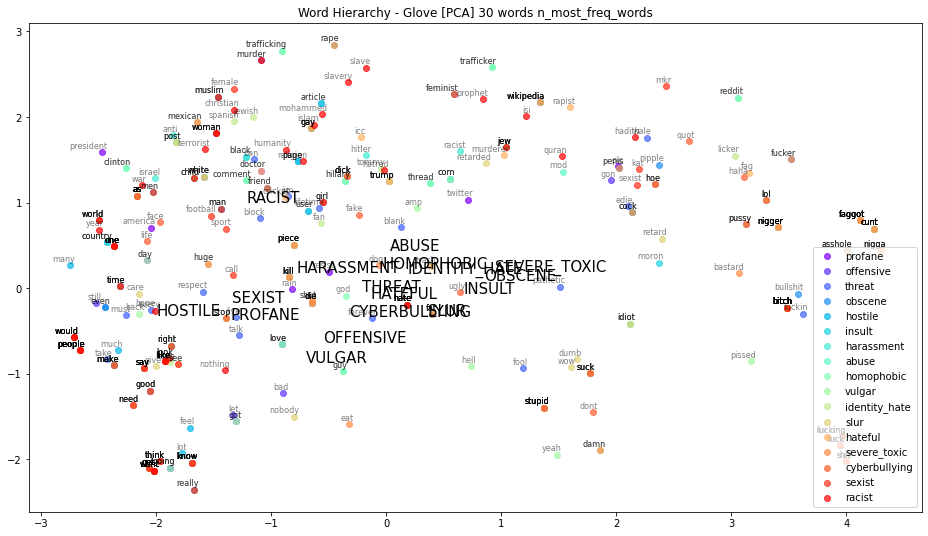

In [41]:
plotPCA(f"Word Hierarchy - Glove [PCA] {n_significant_words} words {words_column}",unique_labels, word_clusters, embedding_clusters,
        f"Word Hierarchy - Glove [PCA] {n_significant_words} words {words_column}.png")

### fasttext embedings (pretrained) visualisations

In [36]:
# Run first time only to download model
import fasttext.util
#print('import')
#fasttext.util.download_model('en', if_exists = 'ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

# Chaya used: https://fasttext.cc/docs/en/crawl-vectors.html
# It includes both Common Crawl and Wikipedia - file cc.en.300.bin.

model_gn = load_facebook_vectors("cc.en.300.bin")

MemoryError: Unable to allocate 4.47 GiB for an array with shape (2000000, 300) and data type float64

In [ ]:
n_significant_words=10
word_clusters, embedding_clusters = get_word_embeddings(unique_labels, df_labels, 'n_most_freq_words', model_gn_glove, n_significant_words)

In [ ]:
plotTSNE(f"Word Hierarchy - Fasttext [t-SNE] {n_significant_words} words {words_column}", unique_labels, word_clusters,embedding_clusters, 
         f"Word Hierarchy - Fasttext [t-SNE] {n_significant_words} words {words_column}.png")

In [ ]:
plotMDS(f"Word Hierarchy - Fasttext [MDS] {n_significant_words} words {words_column}",unique_labels, word_clusters, embedding_clusters, 
        f"Word Hierarchy - Fasttext [MDS] {n_significant_words} words {words_column}.png")

In [ ]:
plotPCA(f"Word Hierarchy - Fasttext [PCA] {n_significant_words} words {words_column}",unique_labels, word_clusters, embedding_clusters,
        f"Word Hierarchy - Fasttext [PCA] {n_significant_words} words {words_column}.png")